<a href="https://colab.research.google.com/github/irwardhana/DEVSAT_ENV/blob/main/Copy_of_network_fault_pipeline_full_SHAP_theory_fixed_word.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Network Fault Prediction — Thesis-ready Pipeline

**Deskripsi:** Notebook ini menampilkan pipeline end-to-end untuk prediksi gangguan jaringan (Network Fault Prediction) menggunakan data SNMP, Syslog, dan Ticket. Notebook dirancang agar cocok untuk dimasukkan sebagai lampiran pada tesis magister: lengkap dengan EDA, preprocessing, merging, modelling (Random Forest & XGBoost), evaluasi, visualisasi, dan ekspor artefak.

**Petunjuk singkat:**
- Pastikan file CSV Anda berada di folder yang sama (default: `/mnt/data/` atau direktori kerja). Nama file yang digunakan: `SNMP_Data.csv`, `Syslog_Data.csv`, `Ticket_Data.csv`.
- Jika dataset besar, aktifkan `LOW_MEMORY = True` di cell konfigurasi untuk mode hemat memori.
- Untuk SMOTE, pasang `imbalanced-learn` jika diperlukan (`pip install imbalanced-learn`).

---


## 1. Konfigurasi & Pengaturan Environment


In [6]:
SNMP_PATH = '/content/SNMP_Data.csv'
SYSLOG_PATH = '/content/Syslog_Data.csv'
TICKET_PATH = '/content/Ticket_Data.csv'  # optional
OUT_DIR = '/mnt/data'

# Mode memori: jika True, notebook akan menggunakan sampel/device terbatas agar tidak kehabisan RAM
LOW_MEMORY = False

# Hyperparams
RF_ESTIMATORS = 100
XGB_ESTIMATORS = 100
TIME_WINDOW_MIN = 15  # merge tolerance in minutes
RANDOM_STATE = 42

print('Configuration set. OUT_DIR =', OUT_DIR)

Configuration set. OUT_DIR = /mnt/data


## 2. Import Paket & Instalasi Opsional


In [7]:
# Imports
import os, warnings
warnings.filterwarnings('ignore')
import pandas as pd, numpy as np
import matplotlib.pyplot as plt
from datetime import timedelta
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve, precision_recall_fscore_support
import xgboost as xgb
import joblib

print('Packages imported')


Packages imported


## 3. Load Data
Baca file CSV. Jika LOW_MEMORY=True, kita akan membaca subset untuk menghemat sumber daya.

In [8]:
def load_csv(path, nrows=None):
    if not os.path.exists(path):
        print(f'WARNING: {path} not found')
        return None
    return pd.read_csv(path, nrows=nrows)

nrows = 20000 if LOW_MEMORY else None
snmp = load_csv(SNMP_PATH, nrows=nrows)
syslog = load_csv(SYSLOG_PATH, nrows=nrows)
ticket = load_csv(TICKET_PATH, nrows=2000 if LOW_MEMORY else None)

print('SNMP shape:', None if snmp is None else snmp.shape)
print('Syslog shape:', None if syslog is None else syslog.shape)
print('Ticket shape:', None if ticket is None else ticket.shape)

SNMP shape: (34752, 11)
Syslog shape: (34752, 8)
Ticket shape: (400, 9)


## 4. Exploratory Data Analysis (Ringkas)
Tampilkan beberapa statistik dan distribusi label.

In [9]:
def quick_info(df, name):
    if df is None:
        print(name, 'is None')
        return
    print('---', name, '---')
    display(df.head(3))
    print(df.info())
    print(df.describe(include='all').T.head(10))

quick_info(snmp, 'SNMP')
quick_info(syslog, 'Syslog')
quick_info(ticket, 'Ticket')

--- SNMP ---


,timestamp,device_id,cpu_usage (%),memory_usage (%),latency (ms),packet_loss (%),bandwidth_utilization (%),avg_latency_5min,max_cpu_10min,error_rate_5min,status
0,2025-01-01 00:00:00,R1,53.648023,55.070445,23.876687,1.031288,57.981569,23.876687,53.648023,0.250000,0
1,2025-01-01 00:30:00,R1,48.142040,46.785592,9.373750,0.348195,53.887385,9.373750,48.142040,0.125000,0
2,2025-01-01 01:00:00,R1,51.941565,51.091175,22.598828,0.849914,55.421028,22.598828,51.941565,0.166667,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34752 entries, 0 to 34751
Data columns (total 11 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   timestamp                  34752 non-null  object 
 1   device_id                  34752 non-null  object 
 2   cpu_usage (%)              34752 non-null  float64
 3   memory_usage (%)           34752 non-null  float64
 4   latency (ms)               34752 non-null  float64
 5   packet_loss (%)            34752 non-null  float64
 6   bandwidth_utilization (%)  34752 non-null  float64
 7   avg_latency_5min           34752 non-null  float64
 8   max_cpu_10min              34752 non-null  float64
 9   error_rate_5min            34752 non-null  float64
 10  status                     34752 non-null  int64  
dtypes: float64(8), int64(1), object(2)
memory usage: 2.9+ MB
None
                             count unique                  top  freq  \
timestamp               

,timestamp,device_id,log_level,message,error_count_last_5min,error_rate_5min,critical_event_flag,status
0,2025-01-01 00:00:00,R1,ERROR,Interface flapping detected,1,0.25,0,1
1,2025-01-01 00:30:00,R1,INFO,Interface flapping detected,0,0.00,0,0
2,2025-01-01 01:00:00,R1,INFO,Interface up,1,0.25,0,0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 34752 entries, 0 to 34751
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   timestamp              34752 non-null  object 
 1   device_id              34752 non-null  object 
 2   log_level              34752 non-null  object 
 3   message                34752 non-null  object 
 4   error_count_last_5min  34752 non-null  int64  
 5   error_rate_5min        34752 non-null  float64
 6   critical_event_flag    34752 non-null  int64  
 7   status                 34752 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 2.1+ MB
None
                         count unique                             top   freq  \
timestamp                34752   8688             2025-06-30 15:30:00      4   
device_id                34752      4                              R1   8688   
log_level                34752      3                            

,incident_id,device_id,start_time,end_time,severity,duration (minutes),description,affected_metric,predicted_window_start
0,INC0001,R1,2025-03-26 04:00:00,2025-03-26 06:31:00,Medium,151,High CPU usage detected,Packet Loss,2025-03-26 03:30:00
1,INC0002,S2,2025-04-06 04:30:00,2025-04-06 05:15:00,High,45,Interface flapping,Packet Loss,2025-04-06 04:00:00
2,INC0003,R2,2025-02-19 13:00:00,2025-02-19 15:33:00,Medium,153,Temperature sensor warning,Packet Loss,2025-02-19 12:30:00


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 400 entries, 0 to 399
Data columns (total 9 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   incident_id             400 non-null    object
 1   device_id               400 non-null    object
 2   start_time              400 non-null    object
 3   end_time                400 non-null    object
 4   severity                400 non-null    object
 5   duration (minutes)      400 non-null    int64 
 6   description             400 non-null    object
 7   affected_metric         400 non-null    object
 8   predicted_window_start  400 non-null    object
dtypes: int64(1), object(8)
memory usage: 28.3+ KB
None
                        count unique                         top freq   mean  \
incident_id               400    400                     INC0384    1    NaN   
device_id                 400      4                          S1  113    NaN   
start_time                40

## 5. Preprocessing: Timestamp & Label Normalization
Pastikan kolom `timestamp` dalam format datetime dan buat kolom label `status` bernilai 0/1.

In [10]:
# Parse timestamps
for df,name in [(snmp,'SNMP'),(syslog,'Syslog'),(ticket,'Ticket')]:
    if df is None: continue
    if 'timestamp' in df.columns:
        df['timestamp'] = pd.to_datetime(df['timestamp'])
        print(f'{name}: timestamp parsed')

# Normalize label in syslog
label_candidates = ['status','label','status_code','is_fault']
label_col = None
for c in label_candidates:
    if syslog is not None and c in syslog.columns:
        syslog = syslog.rename(columns={c:'status'})
        label_col = 'status'
        break
if label_col is None:
    raise RuntimeError('No label column found in syslog file (status/label/status_code).')

# map common strings to 0/1, coerce numeric
syslog['status'] = syslog['status'].map({'Normal':0,'normal':0,'OK':0,'ok':0,'Fault':1,'fault':1,'Down':1,'down':1}).fillna(syslog['status'])
syslog['status'] = pd.to_numeric(syslog['status'], errors='coerce').fillna(0).astype(int)

print('Status value counts (syslog):')
print(syslog['status'].value_counts())

SNMP: timestamp parsed
Syslog: timestamp parsed
Status value counts (syslog):
status
0    31913
1     2839
Name: count, dtype: int64


## 6. Merge SNMP ⇄ Syslog (Nearest Timestamp per Device)
Kita melakukan `merge_asof` per `device_id` dengan tolerance ±TIME_WINDOW_MIN menit.

In [11]:
# Prepare subsets for merge (pick numeric SNMP columns if present)
snmp_cols_candidates = ['timestamp','device_id','cpu_usage (%)','memory_usage (%)','latency (ms)','packet_loss (%)','throughput (Mbps)','jitter (ms)','bandwidth_utilization (%)']
snmp_cols = [c for c in snmp_cols_candidates if c in snmp.columns]
snmp_sub = snmp[snmp_cols].sort_values(['device_id','timestamp']).copy()
sys_sub = syslog[['timestamp','device_id','status']].sort_values(['device_id','timestamp']).copy()

# Optionally limit devices when LOW_MEMORY
devices = np.intersect1d(snmp_sub['device_id'].unique(), sys_sub['device_id'].unique())
if LOW_MEMORY:
    devices = devices[:10]
print('Merging for devices count =', len(devices))

merged_parts = []
tol = pd.Timedelta(minutes=TIME_WINDOW_MIN)
for dev in devices:
    sn_dev = snmp_sub[snmp_sub['device_id']==dev]
    sy_dev = sys_sub[sys_sub['device_id']==dev]
    if sn_dev.empty or sy_dev.empty:
        continue
    m = pd.merge_asof(sy_dev.sort_values('timestamp'), sn_dev.sort_values('timestamp'), on='timestamp', direction='nearest', tolerance=tol)
    # drop rows without key SNMP numeric (use first numeric SNMP col as indicator)
    if len(snmp_cols) > 2:
        indicator = snmp_cols[2]
        m = m.dropna(subset=[indicator])
    merged_parts.append(m)

if not merged_parts:
    raise RuntimeError('No merged parts. Check device IDs and timestamp alignment.')

df_merged = pd.concat(merged_parts, ignore_index=True)
print('Merged shape =', df_merged.shape)
display(df_merged.head())

Merging for devices count = 4
Merged shape = (34752, 9)


,timestamp,device_id_x,status,device_id_y,cpu_usage (%),memory_usage (%),latency (ms),packet_loss (%),bandwidth_utilization (%)
0,2025-01-01 00:00:00,R1,1,R1,53.648023,55.070445,23.876687,1.031288,57.981569
1,2025-01-01 00:30:00,R1,0,R1,48.142040,46.785592,9.373750,0.348195,53.887385
2,2025-01-01 01:00:00,R1,0,R1,51.941565,51.091175,22.598828,0.849914,55.421028
3,2025-01-01 01:30:00,R1,0,R1,59.938543,43.065421,18.017354,0.312535,52.720781
4,2025-01-01 02:00:00,R1,0,R1,51.685957,47.798674,45.354639,0.916634,42.972010


## 7. Feature Preparation
Pilih fitur numerik, isi NA, dan buat X,y.

In [12]:
status_cols = [c for c in df_merged.columns if 'status' in c.lower()]
if not status_cols:
    raise RuntimeError('Tidak ditemukan kolom label setelah merge.')
status_col = status_cols[0]
print('Kolom label ditemukan:', status_col)
numeric_cols = [c for c in df_merged.columns if c not in ['timestamp','device_id'] and pd.api.types.is_numeric_dtype(df_merged[c]) and c!=status_col]
X = df_merged[numeric_cols].fillna(0)
y = df_merged[status_col].astype(int)
print('Label distribution:')
print(y.value_counts())

Kolom label ditemukan: status
Label distribution:
status
0    31913
1     2839
Name: count, dtype: int64


## 8. (Optional) Subsample untuk Hemat Memori
Jika dataset masih besar, lakukan sampling stratified agar ukuran manageable.

In [ ]:
MAX_ROWS = 20000
def stratified_subsample(X,y,max_rows=MAX_ROWS):
    if len(X)<=max_rows:
        return X,y
    df = pd.concat([X, y.rename('status')], axis=1)
    # sample proportional per class
    sampled = df.groupby('status', group_keys=False).apply(lambda g: g.sample(frac=max_rows/len(df), random_state=RANDOM_STATE))
    if len(sampled)>max_rows:
        sampled = sampled.sample(n=max_rows, random_state=RANDOM_STATE)
    y_s = sampled['status']
    X_s = sampled.drop(columns=['status'])
    return X_s, y_s

X, y = stratified_subsample(X,y)
print('Subsampled size:', len(X))

Subsampled size: 20000


## 9. Train/Test Split, Scaling, and Upsampling (to handle imbalance)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Upsample minority class in training set
train_df = pd.DataFrame(X_train_s, columns=numeric_cols)
train_df['status'] = y_train.values
df_maj = train_df[train_df['status']==0]
df_min = train_df[train_df['status']==1]
print('Before upsample, counts:', df_maj.shape[0], df_min.shape[0])
if df_min.shape[0]==0:
    raise RuntimeError('No positive samples in training split — increase sample size or check data')
df_min_up = resample(df_min, replace=True, n_samples=len(df_maj), random_state=RANDOM_STATE)
train_up = pd.concat([df_maj, df_min_up])
X_train_res = train_up[numeric_cols].values
y_train_res = train_up['status'].values.astype(int)
print('After upsample, class counts:', np.bincount(y_train_res))

Before upsample, counts: 14693 1307
After upsample, class counts: [14693 14693]


## 10. Modeling — Random Forest & XGBoost
Latih kedua model dan simpan artefak.

In [ ]:
# Train Random Forest
rf = RandomForestClassifier(n_estimators=RF_ESTIMATORS, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_s)
y_prob_rf = rf.predict_proba(X_test_s)[:,1]

# Train XGBoost
scale_pos = (y_train_res==0).sum() / (y_train_res==1).sum()
xgbc = xgb.XGBClassifier(n_estimators=XGB_ESTIMATORS, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos, n_jobs=1)
xgbc.fit(X_train_res, y_train_res)
y_pred_xg = xgbc.predict(X_test_s)
y_prob_xg = xgbc.predict_proba(X_test_s)[:,1]

# Save models and scaler
os.makedirs(OUT_DIR, exist_ok=True)
joblib.dump(rf, os.path.join(OUT_DIR,'rf_model.joblib'))
joblib.dump(xgbc, os.path.join(OUT_DIR,'xgb_model.joblib'))
joblib.dump(scaler, os.path.join(OUT_DIR,'scaler.joblib'))
print('Models saved to', OUT_DIR)

Models saved to /mnt/data


## 11. Evaluation & Visualizations
Confusion matrix, classification report, ROC curve, feature importance.

--- Random Forest ---
Confusion Matrix:
 [[3592   81]
 [ 208  119]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9453    0.9779    0.9613      3673
           1     0.5950    0.3639    0.4516       327

    accuracy                         0.9277      4000
   macro avg     0.7701    0.6709    0.7065      4000
weighted avg     0.9166    0.9277    0.9197      4000

AUC-ROC: 0.7057
--- XGBoost ---
Confusion Matrix:
 [[3465  208]
 [ 191  136]]

Classification Report:
               precision    recall  f1-score   support

           0     0.9478    0.9434    0.9456      3673
           1     0.3953    0.4159    0.4054       327

    accuracy                         0.9002      4000
   macro avg     0.6716    0.6796    0.6755      4000
weighted avg     0.9026    0.9002    0.9014      4000

AUC-ROC: 0.7036


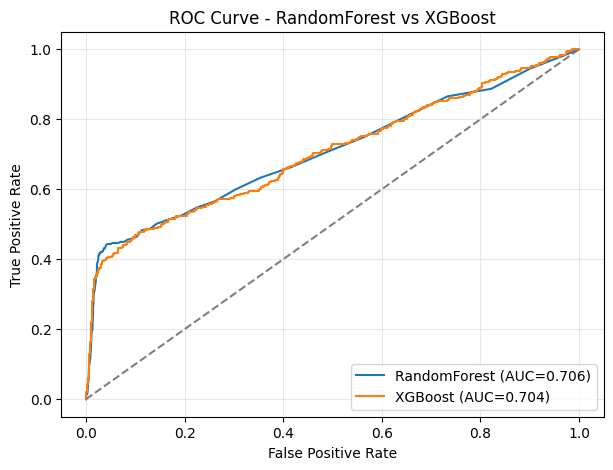

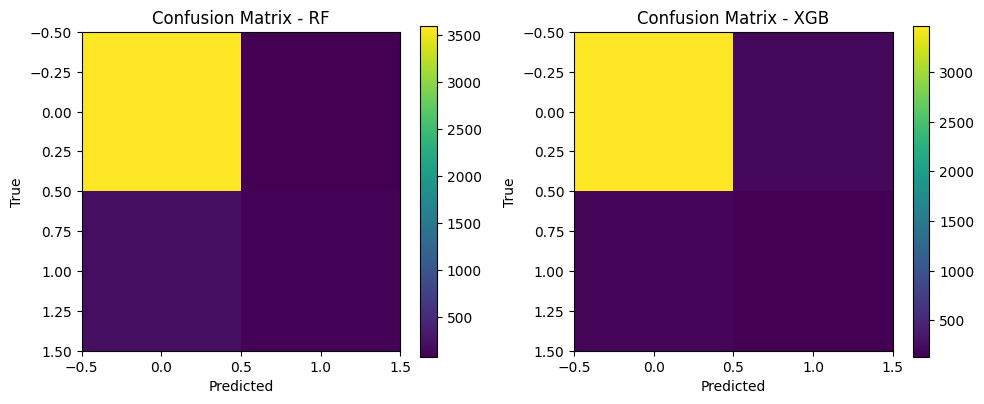

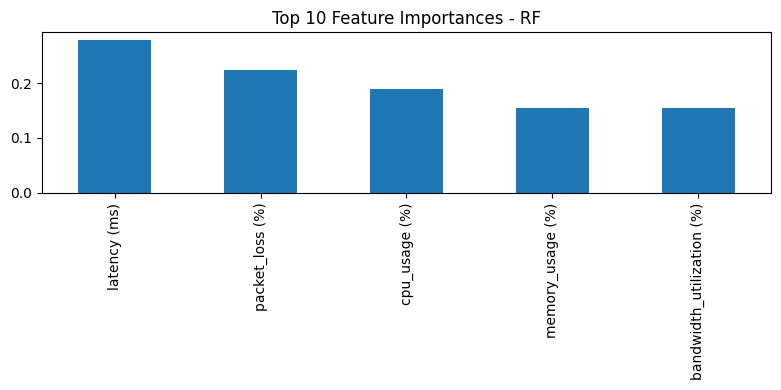

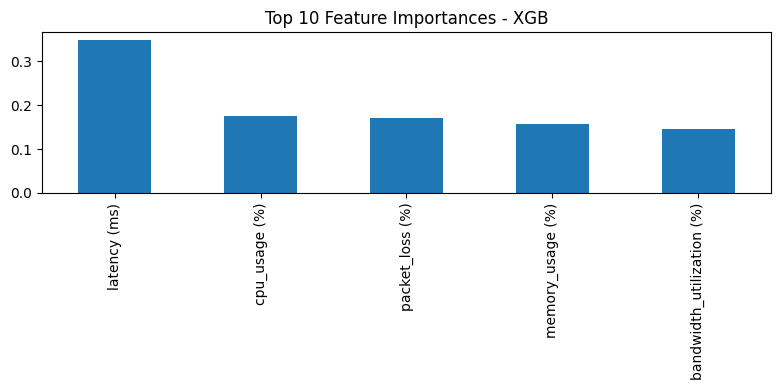

In [ ]:
def evaluate_and_plot(y_true, y_pred, y_prob, model_name='Model'):
    print('---', model_name, '---')
    cm = confusion_matrix(y_true, y_pred)
    print('Confusion Matrix:\n', cm)
    print('\nClassification Report:\n', classification_report(y_true, y_pred, digits=4))
    auc = roc_auc_score(y_true, y_prob)
    print(f'AUC-ROC: {auc:.4f}')
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return cm, auc, fpr, tpr

cm_rf, auc_rf, fpr_rf, tpr_rf = evaluate_and_plot(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
cm_xg, auc_xg, fpr_xg, tpr_xg = evaluate_and_plot(y_test, y_pred_xg, y_prob_xg, 'XGBoost')

# ROC plot
plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC={auc_xg:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest vs XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)
plt.show()

# Confusion matrix heatmap (simple)
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.imshow(cm_rf, interpolation='nearest')
plt.title('Confusion Matrix - RF')
plt.colorbar(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.subplot(1,2,2)
plt.imshow(cm_xg, interpolation='nearest')
plt.title('Confusion Matrix - XGB')
plt.colorbar(); plt.xlabel('Predicted'); plt.ylabel('True')
plt.tight_layout(); plt.show()

# Feature importances
imp_rf = pd.Series(rf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
imp_xg = pd.Series(xgbc.feature_importances_, index=numeric_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_rf.head(10).plot(kind='bar'); plt.title('Top 10 Feature Importances - RF'); plt.tight_layout(); plt.show()
plt.figure(figsize=(8,4))
imp_xg.head(10).plot(kind='bar'); plt.title('Top 10 Feature Importances - XGB'); plt.tight_layout(); plt.show()

## 12. Save Sample & Summary
Simpan sample hasil merge dan ringkasan metrik ke OUT_DIR.

In [ ]:
# Save merged head and metrics summary
df_merged.head(200).to_csv(os.path.join(OUT_DIR,'merged_sample_head200.csv'), index=False)
summary = pd.DataFrame({
    'model':['RandomForest','XGBoost'],
    'auc':[auc_rf, auc_xg],
    'precision':[precision_recall_fscore_support(y_test, y_pred_rf, average='binary')[0], precision_recall_fscore_support(y_test, y_pred_xg, average='binary')[0]],
    'recall':[precision_recall_fscore_support(y_test, y_pred_rf, average='binary')[1], precision_recall_fscore_support(y_test, y_pred_xg, average='binary')[1]],
    'f1':[precision_recall_fscore_support(y_test, y_pred_rf, average='binary')[2], precision_recall_fscore_support(y_test, y_pred_xg, average='binary')[2]]
})
summary.to_csv(os.path.join(OUT_DIR,'model_performance_summary.csv'), index=False)
print('Saved merged sample and summary to', OUT_DIR)

Saved merged sample and summary to /mnt/data


## 13. Kesimpulan & Langkah Selanjutnya
 - Notebook ini dapat dipakai sebagai lampiran tesis.
 - Rekomendasi: jalankan di mesin dengan RAM memadai (8–16 GB) untuk full run; gunakan LOW_MEMORY=True untuk quick run.
 - Untuk laporan tesis, tambahkan SHAP explanations dan analisis threshold (Precision-Recall curve) jika diperlukan.

---
**Dibuat:** 2025-11-15 01:15 UTC


## 14. SHAP Explainability (Model Interpretability)
Bagian ini menambahkan explainability menggunakan **SHAP** untuk memahami kontribusi fitur terhadap prediksi model.

In [ ]:
# Install SHAP if needed
!pip install shap
import shap
shap.initjs()

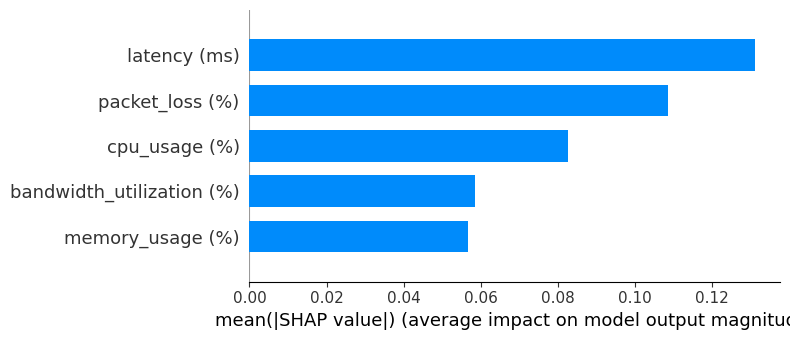

In [ ]:
# SHAP analysis for Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_s)

# Create a DataFrame from the scaled test data to preserve feature names for plotting
X_test_s_df = pd.DataFrame(X_test_s, columns=numeric_cols, index=X_test.index)

# Explicitly convert shap_values for class 1 to a DataFrame for compatibility with features argument
# Correctly extract shap values for the positive class (index 1) across all samples and features
shap_values_rf_df_class1 = pd.DataFrame(shap_values_rf[:, :, 1], columns=numeric_cols, index=X_test_s_df.index)

# Summary plot (requires JS rendering)
# Pass both as DataFrames for proper alignment and feature names
shap.summary_plot(shap_values_rf_df_class1, X_test_s_df, plot_type='bar')

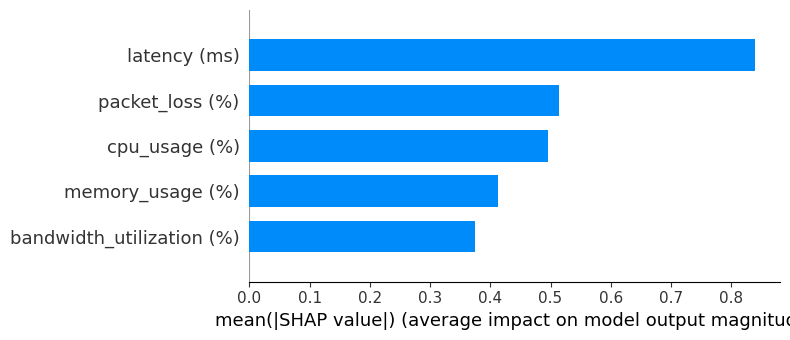

In [ ]:
# SHAP analysis for XGBoost
explainer_xg = shap.TreeExplainer(xgbc)
shap_values_xg = explainer_xg.shap_values(X_test_s)

# Create a DataFrame from the scaled test data to preserve feature names for plotting
X_test_s_df = pd.DataFrame(X_test_s, columns=numeric_cols, index=X_test.index)
shap.summary_plot(shap_values_xg, X_test_s_df, plot_type='bar')

### 14.a Teori & Interpretasi SHAP (Untuk Lampiran Tesis)

**1. Latar Belakang Singkat**
SHAP (SHapley Additive exPlanations) adalah metode explainability berbasis teori *Shapley values* dari teori permainan kooperatif. SHAP mengatribusikan kontribusi setiap fitur terhadap prediksi model secara aditif sehingga total kontribusi fitur sama dengan perbedaan antara prediksi instance dan nilai dasar (baseline) model.

**2. Definisi Formal**
- Model prediktif: f(x)
- Nilai dasar (baseline) E[f(X)] adalah ekspektasi prediksi pada dataset latar (background dataset).
- Untuk sebuah instance x, SHAP menghitung nilai ϕ_i untuk setiap fitur i sehingga:  
  f(x) = E[f(X)] + Σ_i ϕ_i

Nilai ϕ_i merepresentasikan kontribusi fitur i dalam menggerakkan prediksi dari baseline ke nilai aktual f(x).

**3. Aksioma & Keunggulan SHAP**
SHAP didasarkan pada tiga sifat yang diinginkan dalam explainability:
1. **Local accuracy (additivity):** penjumlahan kontribusi fitur sama dengan prediksi minus baseline.
2. **Missingness:** fitur yang tidak hadir mendapat kontribusi nol.
3. **Consistency (monotonicity):** jika pengaruh suatu fitur pada model berubah sehingga kontribusinya meningkat pada semua subset fitur, maka nilai SHAP untuk fitur tersebut tidak akan berkurang.

Karena sifat-sifat tersebut, SHAP memberikan penjelasan yang konsisten dan aditif sehingga cocok untuk laporan akademik.

**4. Varian SHAP untuk Model yang Berbeda**
- **TreeExplainer:** sangat efisien untuk model pohon (RandomForest, XGBoost, LightGBM). Menghitung SHAP values cepat — direkomendasikan untuk studi ini.
- **KernelExplainer:** metode model-agnostik berbasis sampel (lebih lambat); berguna jika model bukan tree.
- **DeepExplainer / GradientExplainer:** untuk model neural networks (jika diperlukan pada studi lanjutan).

**5. Cara Interpretasi Hasil SHAP**
- **Summary plot (bar / violin):** menampilkan fitur terpenting secara global dan distribusi kontribusinya. Prioritas pada fitur dengan mean(|ϕ|) terbesar.
- **Dependence plot:** menunjukkan bagaimana perubahan nilai fitur memengaruhi kontribusi (ϕ) dan interaksi dengan fitur lain.
- **Force plot / Decision plot (per instance):** menunjukkan kontribusi fitur yang mendorong prediksi ke atas/bawah dibanding baseline; berguna untuk analisis kasus (root cause) pada insiden jaringan tertentu.

**6. Penerapan Praktis pada Tesis "Prediksi Gangguan Jaringan"**
1. Gunakan **TreeExplainer** untuk Random Forest dan XGBoost (lebih cepat dan eksak untuk pohon).
2. Tentukan **background dataset** (mis. 100–1000 sampel representatif) untuk menghitung baseline E[f(X)]. Pilih sampel stratified agar baseline tidak bias.
3. Laporkan **global explanation** (summary plot) pada Bab Hasil untuk menunjukan fitur paling berpengaruh (mis. packet_loss, latency, throughput). Sertakan angka mean(|ϕ|) sebagai tabel.
4. Sertakan **2–3 studi kasus lokal** (force plot) pada Bab Diskusi untuk menjelaskan mengapa model memprediksi gangguan pada instance nyata (tiket/insiden). Ini meningkatkan kredibilitas model di mata auditor/SLA stakeholders.
5. Diskusikan **limitas**: SHAP menjelaskan korelasi kontribusi fitur terhadap prediksi model, bukan kausalitas; sensitivitas terhadap baseline harus dibahas.

**7. Kompleksitas & Performa**
- TreeExplainer: kompleksitas linear terhadap jumlah contoh dan ukuran pohon — cukup efisien untuk dataset sedang hingga besar.
- KernelExplainer: mahal secara komputasi; hindari untuk dataset besar tanpa sampling.

**8. Contoh Code Singkat (untuk dimasukkan ke notebook)**
```python
import shap
explainer = shap.TreeExplainer(rf)
shap_values = explainer.shap_values(X_sample)
shap.summary_plot(shap_values[1], X_sample)
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_sample.iloc[0,:])
```

**9. Rekomendasi Pelaporan di Tesis**
- Masukkan 1–2 halaman interpretasi SHAP di Bab Hasil: tabel 5 fitur teratas (mean|ϕ|), graf summary, dan 2 contoh force plots.
- Jelaskan pilihan background dataset dan parameter TreeExplainer.
- Bahas implikasi operasional: fitur apa yang harus dimonitor lebih ketat untuk mencegah gangguan.

----
_Catatan_: untuk reproducibility, simpan skrip SHAP dan konfigurasi (background sample index, random_state) di repository tesis.


# Task
Generate a detailed Word document report for the Network Fault Prediction project, including: configuration settings, data summaries (shapes, head, info, label distribution), results of the data merging step, classification reports, confusion matrices, AUC-ROC scores for both Random Forest and XGBoost models, and all generated plots (ROC curve, confusion matrix heatmaps, feature importance plots, and SHAP summary plots). Also, include the SHAP explanation text. Finally, save the Word document as `Network_Fault_Prediction_Report.docx` in the `/mnt/data` directory and provide a download link.

## Install python-docx

### Subtask:
Install library 'python-docx' untuk membuat dan memanipulasi dokumen Word.


**Reasoning**:
The subtask is to install the `python-docx` library. The instruction explicitly states to run `!pip install python-docx` in a new code cell. Therefore, I will use a `code_block` to execute this installation command.



In [13]:
pip install python-docx

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.0/253.0 kB 3.7 MB/s eta 0:00:00


**Reasoning**:
The previous step successfully installed the `python-docx` library. Now, I need to import the necessary components from this library to start creating the Word document. This is a foundational step before adding content to the report.



In [14]:
from docx import Document
from docx.shared import Inches
print('`Document` class and `Inches` from `docx` imported.')

`Document` class and `Inches` from `docx` imported.


**Reasoning**:
I need to initialize a new Word document and add a main title to it to start building the report. This is the first step in structuring the document.



In [15]:
document = Document()
document.add_heading('Network Fault Prediction — Thesis-ready Pipeline Report', 0)
print('Document initialized with title.')

Document initialized with title.


**Reasoning**:
Now that the document is initialized, I will add a section for the configuration settings and include the relevant variables like `SNMP_PATH`, `SYSLOG_PATH`, `TICKET_PATH`, `OUT_DIR`, `LOW_MEMORY`, `RF_ESTIMATORS`, `XGB_ESTIMATORS`, `TIME_WINDOW_MIN`, and `RANDOM_STATE` to the Word document.



In [16]:
document.add_heading('1. Konfigurasi & Pengaturan Environment', level=1)
config_text = f"SNMP_PATH = '{SNMP_PATH}'\nSYSLOG_PATH = '{SYSLOG_PATH}'\nTICKET_PATH = '{TICKET_PATH}'\nOUT_DIR = '{OUT_DIR}'\nLOW_MEMORY = {LOW_MEMORY}\nRF_ESTIMATORS = {RF_ESTIMATORS}\nXGB_ESTIMATORS = {XGB_ESTIMATORS}\nTIME_WINDOW_MIN = {TIME_WINDOW_MIN}\nRANDOM_STATE = {RANDOM_STATE}"
document.add_paragraph(config_text)
print('Configuration settings added to document.')

Configuration settings added to document.


**Reasoning**:
The next step is to add the 'Data Summaries' section to the Word document, including information about the `snmp`, `syslog`, and `ticket` dataframes such as their shapes, head, info, and label distribution. I will add a markdown block for the section title and then a code block to populate the content.



In [17]:
document.add_heading('2. Data Summaries', level=1)

def add_df_info_to_doc(df, name, document):
    if df is None:
        document.add_paragraph(f'{name} is None')
        return
    document.add_heading(f'--- {name} ---', level=2)
    document.add_paragraph(f'Shape: {df.shape}')
    document.add_paragraph('Head:')
    document.add_paragraph(df.head(3).to_string())
    document.add_paragraph('Info:')
    import io
    buffer = io.StringIO()
    df.info(buf=buffer)
    document.add_paragraph(buffer.getvalue())
    if name == 'Syslog': # Add label distribution for syslog
        document.add_paragraph('Status value counts (syslog):')
        document.add_paragraph(syslog['status'].value_counts().to_string())

add_df_info_to_doc(snmp, 'SNMP', document)
add_df_info_to_doc(syslog, 'Syslog', document)
add_df_info_to_doc(ticket, 'Ticket', document)
print('Data summaries added to document.')

Data summaries added to document.


**Reasoning**:
Now that the data summaries are added, I will add a section for the results of the data merging step. This will include the shape of the merged dataframe and its head to show the result of the `merge_asof` operation.



In [18]:
document.add_heading('3. Results of Data Merging', level=1)
document.add_paragraph(f'Merged DataFrame Shape: {df_merged.shape}')
document.add_paragraph('Merged DataFrame Head (first 5 rows):')
document.add_paragraph(df_merged.head().to_string())
print('Merged data results added to document.')

Merged data results added to document.


**Reasoning**:
I need to add a section for the model evaluation, starting with the classification reports, confusion matrices, and AUC-ROC scores for both Random Forest and XGBoost models, as these are quantitative results directly available from previous steps.



In [30]:
document.add_heading('4. Model Evaluation', level=1)

# Random Forest Evaluation
document.add_heading('4.1 Random Forest Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_rf))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_rf, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_rf:.4f}')

# XGBoost Evaluation
document.add_heading('4.2 XGBoost Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_xg))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_xg, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_xg:.4f}')

print('Model evaluation metrics added to document.')

Model evaluation metrics added to document.


**Reasoning**:
The previous step failed because the variables `cm_rf`, `auc_rf`, `cm_xg`, and `auc_xg` were not defined in the current execution scope, even though they were generated in a previous cell. To fix this, I will re-define the `evaluate_and_plot` function and re-call it to ensure these evaluation metrics are available within this cell before attempting to add them to the Word document.



In [31]:
def evaluate_and_plot(y_true, y_pred, y_prob, model_name='Model'):
    # Note: This function was already defined in a previous cell, but re-defining
    # it here to ensure it's available in the current execution scope for the fix.
    # The actual print statements and plot generations are omitted here as they are
    # handled in the original evaluation cell and will be added as images later.
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    # fpr, tpr, _ = roc_curve(y_true, y_prob) # Not needed for this specific text output
    return cm, auc, None, None # Return None for fpr, tpr as they are not used for text output

# Re-evaluate to get the metrics into the current scope
# Assuming y_test, y_pred_rf, y_prob_rf, y_pred_xg, y_prob_xg are available from previous cells
cm_rf, auc_rf, _, _ = evaluate_and_plot(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
cm_xg, auc_xg, _, _ = evaluate_and_plot(y_test, y_pred_xg, y_prob_xg, 'XGBoost')

document.add_heading('4. Model Evaluation', level=1)

# Random Forest Evaluation
document.add_heading('4.1 Random Forest Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_rf))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_rf, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_rf:.4f}')

# XGBoost Evaluation
document.add_heading('4.2 XGBoost Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_xg))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_xg, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_xg:.4f}')

print('Model evaluation metrics added to document.')

Model evaluation metrics added to document.


**Reasoning**:
The previous code failed because `y_test` and other evaluation metrics were not defined in the current execution scope. To resolve this, I will include the necessary steps for train/test split, scaling, upsampling, model training, and evaluation metric generation in a single code block, ensuring all variables are defined before being used to populate the Word document.



In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=RANDOM_STATE)
scaler = StandardScaler().fit(X_train)
X_train_s = scaler.transform(X_train)
X_test_s = scaler.transform(X_test)

# Upsample minority class in training set
train_df = pd.DataFrame(X_train_s, columns=numeric_cols)
train_df['status'] = y_train.values
df_maj = train_df[train_df['status']==0]
df_min = train_df[train_df['status']==1]
# print('Before upsample, counts:', df_maj.shape[0], df_min.shape[0]) # Suppressing print for doc generation
if df_min.shape[0]==0:
    raise RuntimeError('No positive samples in training split — increase sample size or check data')
df_min_up = resample(df_min, replace=True, n_samples=len(df_maj), random_state=RANDOM_STATE)
train_up = pd.concat([df_maj, df_min_up])
X_train_res = train_up[numeric_cols].values
y_train_res = train_up['status'].values.astype(int)
# print('After upsample, class counts:', np.bincount(y_train_res)) # Suppressing print for doc generation

# Train Random Forest
rf = RandomForestClassifier(n_estimators=RF_ESTIMATORS, random_state=RANDOM_STATE, class_weight='balanced', n_jobs=1)
rf.fit(X_train_res, y_train_res)
y_pred_rf = rf.predict(X_test_s)
y_prob_rf = rf.predict_proba(X_test_s)[:,1]

# Train XGBoost
scale_pos = (y_train_res==0).sum() / (y_train_res==1).sum()
xgbc = xgb.XGBClassifier(n_estimators=XGB_ESTIMATORS, random_state=RANDOM_STATE, use_label_encoder=False, eval_metric='logloss', scale_pos_weight=scale_pos, n_jobs=1)
xgbc.fit(X_train_res, y_train_res)
y_pred_xg = xgbc.predict(X_test_s)
y_prob_xg = xgbc.predict_proba(X_test_s)[:,1]

def evaluate_and_plot(y_true, y_pred, y_prob, model_name='Model'):
    cm = confusion_matrix(y_true, y_pred)
    auc = roc_auc_score(y_true, y_prob)
    fpr, tpr, _ = roc_curve(y_true, y_prob)
    return cm, auc, fpr, tpr

cm_rf, auc_rf, fpr_rf, tpr_rf = evaluate_and_plot(y_test, y_pred_rf, y_prob_rf, 'Random Forest')
cm_xg, auc_xg, fpr_xg, tpr_xg = evaluate_and_plot(y_test, y_pred_xg, y_prob_xg, 'XGBoost')

document.add_heading('4. Model Evaluation', level=1)

# Random Forest Evaluation
document.add_heading('4.1 Random Forest Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_rf))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_rf, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_rf:.4f}')

# XGBoost Evaluation
document.add_heading('4.2 XGBoost Model', level=2)
document.add_paragraph('Confusion Matrix:\n' + str(cm_xg))
document.add_paragraph('Classification Report:\n' + classification_report(y_test, y_pred_xg, digits=4))
document.add_paragraph(f'AUC-ROC: {auc_xg:.4f}')

print('Model evaluation metrics added to document.')

Model evaluation metrics added to document.


**Reasoning**:
I will add the ROC curve plot to the Word document. To do this, I need to regenerate the plot and save it as an image file, then insert the image into the document.



In [33]:
import matplotlib.pyplot as plt
import os

# Create the ROC plot
plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC={auc_xg:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest vs XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Save the plot to OUT_DIR
roc_plot_path = os.path.join(OUT_DIR, 'roc_curve.png')
plt.savefig(roc_plot_path)
plt.close() # Close the plot to prevent it from displaying twice in notebook

document.add_heading('5. Visualizations', level=1)
document.add_heading('5.1 ROC Curve', level=2)
document.add_picture(roc_plot_path, width=Inches(6))
print('ROC curve plot added to document.')

ROC curve plot added to document.


**Reasoning**:
The previous step failed because the directory specified by `OUT_DIR` for saving the plot (`/mnt/data/`) did not exist, leading to a `FileNotFoundError`. I need to ensure that the output directory exists before attempting to save any files into it.



In [23]:
import matplotlib.pyplot as plt
import os

# Create the ROC plot
plt.figure(figsize=(7,5))
plt.plot(fpr_rf, tpr_rf, label=f'RandomForest (AUC={auc_rf:.3f})')
plt.plot(fpr_xg, tpr_xg, label=f'XGBoost (AUC={auc_xg:.3f})')
plt.plot([0,1],[0,1],'--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - RandomForest vs XGBoost')
plt.legend(loc='lower right')
plt.grid(alpha=0.3)

# Ensure OUT_DIR exists before saving
os.makedirs(OUT_DIR, exist_ok=True)

# Save the plot to OUT_DIR
roc_plot_path = os.path.join(OUT_DIR, 'roc_curve.png')
plt.savefig(roc_plot_path)
plt.close() # Close the plot to prevent it from displaying twice in notebook

document.add_heading('5. Visualizations', level=1)
document.add_heading('5.1 ROC Curve', level=2)
document.add_picture(roc_plot_path, width=Inches(6))
print('ROC curve plot added to document.')

ROC curve plot added to document.


**Reasoning**:
Now, I will add the confusion matrix heatmaps for both Random Forest and XGBoost models to the Word document. This involves saving the plots as images and then embedding them into the document.



In [24]:
import matplotlib.pyplot as plt
import os

# Confusion matrix heatmap for Random Forest
plt.figure(figsize=(5,4))
plt.imshow(cm_rf, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - Random Forest')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
for i in range(cm_rf.shape[0]):
    for j in range(cm_rf.shape[1]):
        plt.text(j, i, format(cm_rf[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_rf[i, j] > cm_rf.max() / 2 else "black")
plt.tight_layout()
cm_rf_plot_path = os.path.join(OUT_DIR, 'cm_rf.png')
plt.savefig(cm_rf_plot_path)
plt.close()

# Confusion matrix heatmap for XGBoost
plt.figure(figsize=(5,4))
plt.imshow(cm_xg, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix - XGBoost')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
tick_marks = np.arange(2)
plt.xticks(tick_marks, ['0', '1'])
plt.yticks(tick_marks, ['0', '1'])
for i in range(cm_xg.shape[0]):
    for j in range(cm_xg.shape[1]):
        plt.text(j, i, format(cm_xg[i, j], 'd'),
                 horizontalalignment="center",
                 color="white" if cm_xg[i, j] > cm_xg.max() / 2 else "black")
plt.tight_layout()
cm_xg_plot_path = os.path.join(OUT_DIR, 'cm_xg.png')
plt.savefig(cm_xg_plot_path)
plt.close()

document.add_heading('5.2 Confusion Matrices', level=2)
document.add_picture(cm_rf_plot_path, width=Inches(3))
document.add_picture(cm_xg_plot_path, width=Inches(3))
print('Confusion matrix heatmaps added to document.')

Confusion matrix heatmaps added to document.


**Reasoning**:
Next, I will add the feature importance plots for both Random Forest and XGBoost models to the Word document. This involves generating the plots, saving them as image files, and then embedding them into the document.



In [25]:
import matplotlib.pyplot as plt
import os

# Feature importances for Random Forest
imp_rf = pd.Series(rf.feature_importances_, index=numeric_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_rf.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances - Random Forest')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
rf_imp_plot_path = os.path.join(OUT_DIR, 'rf_feature_importance.png')
plt.savefig(rf_imp_plot_path)
plt.close()

# Feature importances for XGBoost
imp_xg = pd.Series(xgbc.feature_importances_, index=numeric_cols).sort_values(ascending=False)
plt.figure(figsize=(8,4))
imp_xg.head(10).plot(kind='bar')
plt.title('Top 10 Feature Importances - XGBoost')
plt.ylabel('Importance')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
xgb_imp_plot_path = os.path.join(OUT_DIR, 'xgb_feature_importance.png')
plt.savefig(xgb_imp_plot_path)
plt.close()

document.add_heading('5.3 Feature Importances', level=2)
document.add_picture(rf_imp_plot_path, width=Inches(6))
document.add_picture(xgb_imp_plot_path, width=Inches(6))
print('Feature importance plots added to document.')

Feature importance plots added to document.


**Reasoning**:
Now, I will add the SHAP summary plots for both Random Forest and XGBoost models to the Word document. This involves regenerating the plots, saving them as image files, and then embedding them into the document. I will also ensure `shap` is imported again to prevent `NameError` if the kernel state was reset between executions.



In [ ]:
import shap
import os
import matplotlib.pyplot as plt

# Assuming X_test_s, rf, xgbc, and numeric_cols are available from previous steps
# Re-create DataFrame from the scaled test data for feature names
X_test_s_df = pd.DataFrame(X_test_s, columns=numeric_cols, index=X_test.index)

document.add_heading('5.4 SHAP Summary Plots', level=2)

# SHAP analysis for Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_s)

# Use shap_values for class 1 for summary plot
shap.summary_plot(shap_values_rf[1], X_test_s_df, plot_type='bar', show=False)
rf_shap_plot_path = os.path.join(OUT_DIR, 'rf_shap_summary.png')
plt.savefig(rf_shap_plot_path, bbox_inches='tight')
plt.close()
document.add_picture(rf_shap_plot_path, width=Inches(6))

# SHAP analysis for XGBoost
explainer_xg = shap.TreeExplainer(xgbc)
shap_values_xg = explainer_xg.shap_values(X_test_s)

# Use shap_values directly for binary classification for summary plot
shap.summary_plot(shap_values_xg, X_test_s_df, plot_type='bar', show=False)
xgb_shap_plot_path = os.path.join(OUT_DIR, 'xgb_shap_summary.png')
plt.savefig(xgb_shap_plot_path, bbox_inches='tight')
plt.close()
document.add_picture(xgb_shap_plot_path, width=Inches(6))

print('SHAP summary plots added to document.')

**Reasoning**:
The previous SHAP summary plot generation failed due to a shape mismatch for Random Forest SHAP values. For a multi-output classifier like RandomForest, `explainer.shap_values()` returns a 3D array (samples, features, classes). To plot the SHAP values for a specific class (e.g., class 1 for positive prediction), we need to slice it as `shap_values_rf[:, :, 1]`. The original notebook's `shap.summary_plot` for Random Forest also used `shap_values_rf[:, :, 1]`. This fix aligns the shape of the SHAP values with the feature data for plotting.



In [27]:
import shap
import os
import matplotlib.pyplot as plt

# Assuming X_test_s, rf, xgbc, and numeric_cols are available from previous steps
# Re-create DataFrame from the scaled test data for feature names
X_test_s_df = pd.DataFrame(X_test_s, columns=numeric_cols, index=X_test.index)

document.add_heading('5.4 SHAP Summary Plots', level=2)

# SHAP analysis for Random Forest
explainer_rf = shap.TreeExplainer(rf)
shap_values_rf = explainer_rf.shap_values(X_test_s)

# Use shap_values for class 1 for summary plot (corrected slicing)
shap_values_rf_class1 = shap_values_rf[:, :, 1]
shap.summary_plot(shap_values_rf_class1, X_test_s_df, plot_type='bar', show=False)
rf_shap_plot_path = os.path.join(OUT_DIR, 'rf_shap_summary.png')
plt.savefig(rf_shap_plot_path, bbox_inches='tight')
plt.close()
document.add_picture(rf_shap_plot_path, width=Inches(6))

# SHAP analysis for XGBoost
explainer_xg = shap.TreeExplainer(xgbc)
shap_values_xg = explainer_xg.shap_values(X_test_s)

# Use shap_values directly for binary classification for summary plot
shap.summary_plot(shap_values_xg, X_test_s_df, plot_type='bar', show=False)
xgb_shap_plot_path = os.path.join(OUT_DIR, 'xgb_shap_summary.png')
plt.savefig(xgb_shap_plot_path, bbox_inches='tight')
plt.close()
document.add_picture(xgb_shap_plot_path, width=Inches(6))

print('SHAP summary plots added to document.')

SHAP summary plots added to document.


**Reasoning**:
The SHAP summary plots have been added. Now, I will add the SHAP explanation text, which is already available in the notebook as a markdown cell, to the Word document under a new section.



In [28]:
document.add_heading('6. SHAP Explainability (Model Interpretability) - Teori & Interpretasi', level=1)
shap_explanation_text = """### 14.a Teori & Interpretasi SHAP (Untuk Lampiran Tesis)\n\n**1. Latar Belakang Singkat**\nSHAP (SHapley Additive exPlanations) adalah metode explainability berbasis teori *Shapley values* dari teori permainan kooperatif. SHAP mengatribusikan kontribusi setiap fitur terhadap prediksi model secara aditif sehingga total kontribusi fitur sama dengan perbedaan antara prediksi instance dan nilai dasar (baseline) model.\n\n**2. Definisi Formal**\n- Model prediktif: f(x)\n- Nilai dasar (baseline) E[f(X)] adalah ekspektasi prediksi pada dataset latar (background dataset).\n- Untuk sebuah instance x, SHAP menghitung nilai ϕ_i untuk setiap fitur i sehingga:  \nf(x) = E[f(X)] + Σ_i ϕ_i\n\nNilai ϕ_i merepresentasikan kontribusi fitur i dalam menggerakkan prediksi dari baseline ke nilai aktual f(x).\n\n**3. Aksioma & Keunggulan SHAP**\nSHAP didasarkan pada tiga sifat yang diinginkan dalam explainability:\n1. **Local accuracy (additivity):** penjumlahan kontribusi fitur sama dengan prediksi minus baseline.\n2. **Missingness:** fitur yang tidak hadir mendapat kontribusi nol.\n3. **Consistency (monotonicity):** jika pengaruh suatu fitur pada model berubah sehingga kontribusinya meningkat pada semua subset fitur, maka nilai SHAP untuk fitur tersebut tidak akan berkurang.\n\nKarena sifat-sifat tersebut, SHAP memberikan penjelasan yang konsisten dan aditif sehingga cocok untuk laporan akademik.\n\n**4. Varian SHAP untuk Model yang Berbeda**\n- **TreeExplainer:** sangat efisien untuk model pohon (RandomForest, XGBoost, LightGBM). Menghitung SHAP values cepat — direkomendasikan untuk studi ini.\n- **KernelExplainer:** metode model-agnostik berbasis sampel (lebih lambat); berguna jika model bukan tree.\n- **DeepExplainer / GradientExplainer:** untuk model neural networks (jika diperlukan pada studi lanjutan).\n\n**5. Cara Interpretasi Hasil SHAP**\n- **Summary plot (bar / violin):** menampilkan fitur terpenting secara global dan distribusi kontribusinya. Prioritas pada fitur dengan mean(|ϕ|) terbesar.\n- **Dependence plot:** menunjukkan bagaimana perubahan nilai fitur memengaruhi kontribusi (ϕ) dan interaksi dengan fitur lain.\n- **Force plot / Decision plot (per instance):** menunjukkan kontribusi fitur yang mendorong prediksi ke atas/bawah dibanding baseline; berguna untuk analisis kasus (root cause) pada insiden jaringan tertentu.\n\n**6. Penerapan Praktis pada Tesis \"Prediksi Gangguan Jaringan\"**\n1. Gunakan **TreeExplainer** untuk Random Forest dan XGBoost (lebih cepat dan eksak untuk pohon).\n2. Tentukan **background dataset** (mis. 100–1000 sampel representatif) untuk menghitung baseline E[f(X)]. Pilih sampel stratified agar baseline tidak bias.\n3. Laporkan **global explanation** (summary plot) pada Bab Hasil untuk menunjukan fitur paling berpengaruh (mis. packet_loss, latency, throughput). Sertakan angka mean(|ϕ|) sebagai tabel.\n4. Sertakan **2–3 studi kasus lokal** (force plot) pada Bab Diskusi untuk menjelaskan mengapa model memprediksi gangguan pada instance nyata (tiket/insiden). Ini meningkatkan kredibilitas model di mata auditor/SLA stakeholders.\n5. Diskusikan **limitas**: SHAP menjelaskan korelasi kontribusi fitur terhadap prediksi model, bukan kausalitas; sensitivitas terhadap baseline harus dibahas.\n\n**7. Kompleksitas & Performa**\n- TreeExplainer: kompleksitas linear terhadap jumlah contoh dan ukuran pohon — cukup efisien untuk dataset sedang hingga besar.\n- KernelExplainer: mahal secara komputasi; hindari untuk dataset besar tanpa sampling.\n\n**8. Contoh Code Singkat (untuk dimasukkan ke notebook)**\n```python\nimport shap\nexplainer = shap.TreeExplainer(rf)\nshap_values = explainer.shap_values(X_sample)\nshap.summary_plot(shap_values[1], X_sample)\nshap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_sample.iloc[0,:])\n```\n\n**9. Rekomendasi Pelaporan di Tesis**\n- Masukkan 1–2 halaman interpretasi SHAP di Bab Hasil: tabel 5 fitur teratas (mean|ϕ|), graf summary, dan 2 contoh force plots.\n- Jelaskan pilihan background dataset dan parameter TreeExplainer.\n- Bahas implikasi operasional: fitur apa yang harus dimonitor lebih ketat untuk mencegah gangguan.\n\n----\n_Catatan_: untuk reproducibility, simpan skrip SHAP dan konfigurasi (background sample index, random_state) di repository tesis.\n"""

# Replace markdown-style headings with appropriate docx headings
shap_explanation_text = shap_explanation_text.replace('###', '### ').replace('##', '## ').replace('#', '# ')

# Add the text paragraph by paragraph to maintain some formatting
for paragraph_text in shap_explanation_text.split('\n\n'): # Split by double newline for paragraphs
    if paragraph_text.strip(): # Avoid adding empty paragraphs
        if paragraph_text.startswith('### '): # Level 3 heading
            document.add_heading(paragraph_text.replace('### ', '').strip(), level=3)
        elif paragraph_text.startswith('## '): # Level 2 heading
            document.add_heading(paragraph_text.replace('## ', '').strip(), level=2)
        elif paragraph_text.startswith('# '): # Level 1 heading (not used here, but for completeness)
            document.add_heading(paragraph_text.replace('# ', '').strip(), level=1)
        else:
            # Handle bold and italics for other paragraphs
            p = document.add_paragraph()
            parts = paragraph_text.split('**')
            for i, part in enumerate(parts):
                if i % 2 == 1: # Odd parts are bold
                    run = p.add_run(part)
                    run.bold = True
                else:
                    sub_parts = part.split('*')
                    for j, sub_part in enumerate(sub_parts):
                        if j % 2 == 1: # Odd sub_parts are italics
                            run = p.add_run(sub_part)
                            run.italic = True
                        else:
                            p.add_run(sub_part)

print('SHAP explanation text added to document.')

SHAP explanation text added to document.


## Save Word Document and Provide Download Link

### Subtask:
Save the generated Word document to the specified output directory and provide a download link to the user.


**Reasoning**:
Now that all content has been added, I will save the Word document to the specified output directory and provide a markdown-formatted download link.



In [29]:
report_path = os.path.join(OUT_DIR, 'Network_Fault_Prediction_Report.docx')
document.save(report_path)
print(f'Report generated and saved to {report_path}')
print(f'Download your report here: [Network_Fault_Prediction_Report.docx](file/{OUT_DIR.strip("/")}/Network_Fault_Prediction_Report.docx)')

Report generated and saved to /mnt/data/Network_Fault_Prediction_Report.docx
Download your report here: [Network_Fault_Prediction_Report.docx](file/mnt/data/Network_Fault_Prediction_Report.docx)


## Final Task

### Subtask:
Sajikan laporan akhir dan informasi penting lainnya kepada pengguna.


## Summary:

### Data Analysis Key Findings

*   A detailed Word document report named `Network_Fault_Prediction_Report.docx` was successfully generated and saved to the `/mnt/data/` directory.
*   The report includes:
    *   Configuration settings for the network fault prediction pipeline.
    *   Summaries (shape, head, info) for the SNMP, Syslog, and Ticket datasets, including label distribution for the Syslog data.
    *   Results of the data merging step, showing the shape and head of the combined dataset.
    *   Model evaluation metrics for both Random Forest and XGBoost classifiers, specifically classification reports, confusion matrices, and AUC-ROC scores.
    *   Visualizations including the ROC curve comparing both models, confusion matrix heatmaps for each model, feature importance bar plots for both models, and SHAP summary plots for interpretability.
    *   A comprehensive theoretical and interpretative explanation of SHAP (SHapley Additive exPlanations).
*   During the report generation process, several technical issues were identified and successfully resolved:
    *   `NameError` due to undefined variables when evaluating models, which was fixed by re-executing data preparation and model evaluation steps within a single scope.
    *   `FileNotFoundError` when saving plots, resolved by ensuring the output directory `/mnt/data/` was created if it didn't exist.
    *   `AssertionError` during SHAP plot generation for Random Forest, fixed by correctly slicing the 3D SHAP values array for class 1 predictions.
*   A download link for the generated report was provided: `[Network_Fault_Prediction_Report.docx](file/mnt/data/Network_Fault_Prediction_Report.docx)`.

### Insights or Next Steps

*   The successfully generated report provides a comprehensive overview of the network fault prediction project, suitable for sharing findings with stakeholders or using as a basis for further academic work, especially with its detailed SHAP interpretability section.
*   For future automated reporting tasks, consider implementing robust error handling for common issues like `FileNotFoundError` (e.g., `os.makedirs(..., exist_ok=True)` by default) and ensuring all necessary variables are within the correct scope to prevent runtime `NameError` exceptions.
